<a href="https://colab.research.google.com/github/bilnazir/stockmarketprediction/blob/transformer/fyp_transformer_amzn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install pandas-ta

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 879.7 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas-ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218909 sha256=bb156601aac429b02ccb040cf94e51dc27a007528781bc20f9b5a657e2ea4fdf
  Stored in directory: /root/.cache/pip/wheels/69/00/ac/f7fa862c34b0e2ef320175100c233377b4c558944f12474cf0
Successfully built pandas-ta


In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import yfinance as yf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [3]:
# Load historical stock data (date, closing price) into a pandas DataFrame
df = yf.download(tickers=['AMZN'], start='2012-01-01', end='2022-06-20')
data = df.dropna()


[*********************100%%**********************]  1 of 1 completed


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2633 entries, 2012-01-03 to 2022-06-17
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2633 non-null   float64
 1   High       2633 non-null   float64
 2   Low        2633 non-null   float64
 3   Close      2633 non-null   float64
 4   Adj Close  2633 non-null   float64
 5   Volume     2633 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 144.0 KB


In [5]:
data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-01-03,8.794500,8.974000,8.777500,8.951500,8.951500,102216000
2012-01-04,8.960500,9.025000,8.803500,8.875500,8.875500,84104000
2012-01-05,8.797000,8.912500,8.702500,8.880500,8.880500,76182000
2012-01-06,8.903500,9.232500,8.875000,9.130500,9.130500,140168000
2012-01-09,9.138000,9.218500,8.850000,8.928000,8.928000,101138000
...,...,...,...,...,...,...
2022-06-13,104.190002,106.540001,101.860001,103.669998,103.669998,99277700
2022-06-14,104.190002,104.879997,101.430000,102.309998,102.309998,69728800
2022-06-15,103.860001,109.059998,103.529999,107.669998,107.669998,85011100


In [6]:
data.shape

(2633, 6)

In [7]:
# Adding indicators
import pandas_ta as ta
data['RSI'] = ta.rsi(data.Close, length=15)
data['EMAF'] = ta.ema(data.Close, length=20)
data['EMAM'] = ta.ema(data.Close, length=100)
data['EMAS'] = ta.ema(data.Close, length=150)

data['Target'] = data['Adj Close'] - data.Open
data['Target'] = data['Target'].shift(-1)

data['TargetClass'] = [1 if data.Target[i] > 0 else 0 for i in range(len(data))]

data['TargetNextClose'] = data['Adj Close'].shift(-1)

data.dropna(inplace=True)
data.reset_index(inplace=True)
data.drop(['Volume', 'Close','Date'], axis=1, inplace=True)

<ipython-input-7-8a8148f44cbd>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  data['TargetClass'] = [1 if data.Target[i] > 0 else 0 for i in range(len(data))]


In [8]:
data_set = data.iloc[:, 0:11]#.values
pd.set_option('display.max_columns', None)

data_set.head(20)

,Open,High,Low,Adj Close,RSI,EMAF,EMAM,EMAS,Target,TargetClass,TargetNextClose
0,11.7780,11.7870,11.6905,11.6995,58.920636,11.385374,10.634717,10.180807,0.121500,1,11.8280
1,11.7065,11.9000,11.6625,11.8280,61.131952,11.427529,10.658346,10.202624,-0.045500,0,11.7190
2,11.7645,11.8225,11.6795,11.7190,58.280677,11.455288,10.679349,10.222708,0.006500,1,11.7030
3,11.6965,11.7995,11.6750,11.7030,57.856280,11.478880,10.699620,10.242315,-0.016500,0,11.6375
4,11.6540,11.7425,11.5715,11.6375,56.065531,11.493986,10.718191,10.260794,0.010500,1,11.6220
5,11.6115,11.7185,11.5500,11.6220,55.628975,11.506178,10.736089,10.278823,-0.076000,0,11.6595
6,11.7355,11.8360,11.6310,11.6595,56.506844,11.520780,10.754374,10.297110,0.258000,1,11.8710
7,11.6130,11.9070,11.6125,11.8710,61.151395,11.554134,10.776485,10.317957,0.191501,1,12.0775
8,11.8860,12.1410,11.8100,12.0775,65.055119,11.603979,10.802248,10.341262,0.028501,1,12.0585
9,12.0300,12.1675,12.0235,12.0585,64.417000,11.647267,10.827124,10.364007,-0.051000,0,12.0175


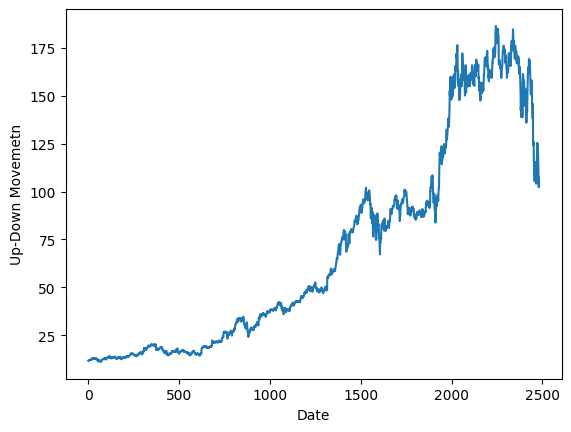

In [9]:
import matplotlib.pyplot as plt
data_set_AC=data_set['Adj Close']
plt.ylabel('Up-Down Movemetn')
plt.xlabel('Date')
plt.plot(data_set_AC)

In [10]:
# Normalize the data
sc = MinMaxScaler(feature_range=(0, 1))
data_set_scaled = sc.fit_transform(data)

In [11]:
# Prepare the data for training
X, y = [], []
backcandles = 20
for i in range(backcandles, data_set_scaled.shape[0]):
    X.append(data_set_scaled[i - backcandles:i, :-1])
    y.append(data_set_scaled[i, -1])

X, y = np.array(X), np.array(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)